In [1]:
from pyspark import SparkContext, SparkConf
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [24]:
NUM_OF_PAGES = [1000, 2000, 4000, 8000, 16000]
THRESHOLD = 0.01
MAX_ITER = 50

In [3]:
# conf = SparkConf().setAppName("Week 7") \
#                   .setMaster("local") \
#                   .set("spark.executor.memory", "16g") \
#                   .set("spark.executor.cores", "4")
conf = SparkConf().setAppName("Week 7") \
                  .setMaster("local")
sc = SparkContext(conf=conf)

In [4]:
def create_setdata(ss):
    record = set()
    for i in ss:
        if i not in record:
            record.add(i)
        else:
            yield record
            record = set()
    if not record:
        yield record
        
def create_dataset(N):
    while True:
        s = np.random.default_rng().zipf(1.2, N*10*10)
        dataset = list(create_setdata(s[s<N]))
        if len(dataset) >= N:
            break
            
    ids = range(N)
    return [(i, s) for i, s in zip(ids, dataset[:N])]

In [5]:
def create_initial_rank(num_pages):
    return {i: 1/num_pages for i in range(num_pages)}

In [6]:
def transition(line, pagerank):
    source = line[0]
    targets = line[1]

    for target in targets:
        yield target, 0.85*pagerank[source]*(1/len(targets))

In [7]:
def compute_diff(old_ranks, new_ranks):
    diff = 0
    
    for key in old_ranks.keys():
        diff += abs(old_ranks[key] - new_ranks[key])
        
    return diff

In [17]:
def compute_pagerank(N):
    dataset = create_dataset(N)

    transitions_rdd = sc.parallelize(dataset) \
                        .cache()
    uniform_dist_rdd = sc.parallelize([(i, 0.15 * 1/N) for i in range(N)]) \
                         .cache()
    pagerank = {i: 1/N for i in range(N)}

    for iter in range(MAX_ITER):
        pagerank_bc = sc.broadcast(pagerank)

        new_pagerank = transitions_rdd.flatMap(lambda line: transition(line, pagerank_bc.value)) \
                                      .union(uniform_dist_rdd) \
                                      .reduceByKey(lambda a, b: a + b) \
                                      .collect()
        new_pagerank = dict(new_pagerank)

        pagerank_bc.unpersist()

        if compute_diff(pagerank, new_pagerank) < THRESHOLD:
            break

        pagerank = new_pagerank

    transitions_rdd.unpersist()

In [25]:
runtimes = []

for N in NUM_OF_PAGES:
    print(f"Number of pages: {N}")
    start_time = time.time()
    compute_pagerank(N)
    runtime = time.time() - start_time
    
    runtimes.append(runtime)
    
print(runtimes)

Number of pages: 1000
Number of pages: 2000
Number of pages: 4000
Number of pages: 8000
Number of pages: 16000
[21.878196001052856, 21.965605974197388, 22.106984853744507, 22.41898226737976, 30.474197149276733]


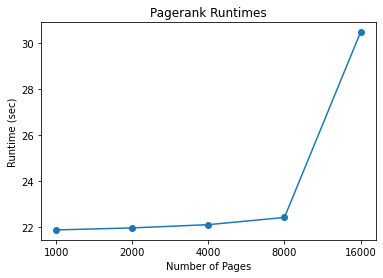

In [26]:
plt.plot(runtimes, marker="o")
plt.title("Pagerank Runtimes")
plt.xlabel("Number of Pages")
plt.ylabel("Runtime (sec)")
plt.xticks(range(len(NUM_OF_PAGES)), labels=NUM_OF_PAGES)
plt.show()